### About the project
Out of all the modern automated decision systems, deep neural networks make explaining their decisions excruciatingly difficult. Being able to do so, however, is essential in many fields, from autonomous vehicles to medical diagnoses to credit scoring, and for reasons ranging from being able to trust the model to privacy concerns to improving model performance.

So, I started with a deep neural network. In my project, I trained a basic Convolutional Neural Network (CNN) that classifies images in the MNIST handwritten digits dataset. I wanted it to "explain its decision-making process." How? I essentially ask it, "What is an image that you'd think is *very much* the digit '1'?" This visually reveals features that it considers important for the digit '1', and if I ask the same question of it many times for all the digits, I can built a mental model of what kinds of images the model will classify as a '1'. I can generate these images by gradient ascent on the neural network's activation score for each target class.

The problem with this approach, though, is what is known to machine learning engineers as "adversarial examples." Essentially, with the way deep neural networks are structured, there would be many images that to a human doesn't look different from a starting "1 image," but that the neural network will classify as a '2'. My goal with this project is to train a Generative Adversarial Network (GAN) to function as a constraint on the images that can be produced with this process, restricting them to stricly "natural images," i.e. images that could feasibly be found in the "real world."

### How to run this project
I've already trained the CNN and GAN to a reasonable degree, and saved them in the '.pt' files. Thus, simply run the cells marked with the bolded **Run:** in order (i.e. 1, 2, 3, etc.)! A CUDA-enabled GPU might be necessary for some cells.

### Code

#### Imports and Initialization
**Run**: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

cuda = False
if torch.cuda.is_available():
    cuda = True
    device = torch.device("cuda")
else: device = torch.device("cpu")
print(f'Using {device} for inference')

Using cuda for inference


#### CNN code
A very simple Convolutional Neural Network with the following architecture:  
 - Convolution turning 1 channel (MNIST is black and white!) into 32 channels -- kernel size 3 (relu activation)
 - Convolution turning 32 channels into 64 -- kernel size 3 (relu activation)
 - Max pooling (with 2x2 kernels) and dropout probability 0.5
 - Two fully connected layers leading to the final softmax to output probabilities
 
**Run**: 2

In [2]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

#### Training the CNN

In [32]:
log_interval = 100
def train_cnn(model, loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()

        output = model(data)

        # Compute CNN's loss on the batch
        loss = F.nll_loss(output, target)

        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), loss.item()))

In [54]:
def test_cnn(model, loader):
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(loader.dataset)

    print('\nTest set: Average loss: {:.6f}, Accuracy: {}/{} ({:.1f}%)\n'.format(
        test_loss, correct, len(loader.dataset),
        100. * correct / len(loader.dataset)))

In [ ]:
# Hyperparameters
seed = 1
epochs = 14
batch_size = 64
test_batch_size = 1000
lr = 1
gamma = 0.7
from_checkpoint=True

torch.manual_seed(seed)

# Prepare DataLoaders
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
train_dataset = datasets.MNIST('./data', train=True, download=True,
                    transform=transform)
test_dataset = datasets.MNIST('./data', train=False,
                    transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)

model = CNN().to(device)
if from_checkpoint:
    model.load_state_dict(torch.load("mnist_cnn.pt"))
optimizer = optim.Adadelta(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

for epoch in range(epochs):
    train_cnn(model, train_loader, optimizer, epoch)
    test_cnn(model, test_loader)
    scheduler.step()

In [55]:
test_batch_size = 1000
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])
test_dataset = datasets.MNIST('./data', train=False,
                    transform=transform)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size)
test_cnn(model, test_loader)


Test set: Average loss: 0.030308, Accuracy: 9914/10000 (99.1%)



#### Save/load
Code to save the CNN right after training, and loading the saved model on later runs.

In [35]:
# torch.save(model.state_dict(), "mnist_cnn.pt")

**Run**: 3  
Initialize the CNN model to be explained with pretrained weights.

In [3]:
model = CNN()
model.load_state_dict(torch.load("mnist_cnn.pt"))
model.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

#### GAN code
This architecture is based on the paper "Conditional Generative Adversarial Nets" by Mehdi Mirza and Simon Osindero.

**Run**: 4

In [4]:
img_size = 28
img_shape = 1, img_size, img_size
n_classes = 10
latent_dim = 100
FloatTensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if cuda else torch.LongTensor
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        self.label_emb = nn.Embedding(n_classes, n_classes)

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        self.model = nn.Sequential(
            *block(latent_dim + n_classes, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
        )
        self.fc1 = nn.Linear(1024, int(np.prod(img_shape)))
        self.activate = nn.Tanh()


    def forward(self, noise, labels):
        gen_input = torch.cat((self.label_emb(labels), noise), -1)
        img = self.model(gen_input)
        img = self.fc1(img)
        img = self.activate(img)
        img = img.view(img.size(0), *img_shape)
        return img

The discriminator is only needed when training the GAN -- it's not necessary for the explanation.

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.label_embedding = nn.Embedding(n_classes, n_classes)

        self.model = nn.Sequential(
            nn.Linear(n_classes + int(np.prod(img_shape)), 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 512),
            nn.Dropout(0.4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
        )

    def forward(self, img, labels):
        d_in = torch.cat((img.view(img.size(0), -1), self.label_embedding(labels)), -1)
        validity = self.model(d_in)
        return validity

**Run**: 5  
Simple code to generate n_samp random noise images as a starting point.

In [6]:
def gen_GAN_noise(n_samp):
    z = Variable(FloatTensor(np.random.normal(0, 1, (n_samp*n_classes, latent_dim))))
    labels = np.array([num for _ in range(n_samp) for num in range(n_classes)])
    labels = Variable(LongTensor(labels))
    return z, labels

This code is useful for checking the success of training the GAN -- not useful for explanation.

In [24]:
def sample_image(generator, n_row, batches_done=0, save=True):
    """Saves a grid of generated digits ranging from 0 to n_classes"""
    z, labels = gen_GAN_noise(n_row)
    gen_imgs = generator(z, labels)
    if save:
        save_image(gen_imgs.data, "images/%d.png" % batches_done, nrow=n_row, normalize=True)
    else:
        grid = make_grid(gen_imgs, nrow=n_row)
        ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
        im = Image.fromarray(ndarr)
        display(im)

The code to actually train the GAN -- not used in explanation.

In [27]:
log_interval = 400
def train_gan(generator, discriminator, loader, optimizer_G, optimizer_D, loss, epoch):
    generator.train()
    discriminator.train()
    for batch_idx, (data, target) in enumerate(loader):
        data, target = data.to(device), target.to(device)

        batch_size = data.shape[0]
        # Prep for computing discriminator loss: adversarial ground truths
        valid = Variable(FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)

        # Prep for real input
        real_imgs = Variable(data.type(FloatTensor))
        labels = Variable(target.type(LongTensor))

        # -----------------
        #  Train Generator
        # -----------------

        optimizer_G.zero_grad()
        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim))))
        gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, batch_size)))

        # Generate a batch of images
        output_g = generator(z, gen_labels)
        # Compute generator's loss on that batch
        validity = discriminator(output_g, gen_labels)
        g_loss = loss(validity, valid)

        g_loss.backward()
        optimizer_G.step()

        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

        # Compute discriminator's loss for real images
        validity_real = discriminator(real_imgs, labels)
        d_real_loss = loss(validity_real, valid)
        # Compute discriminator's loss for fake images
        validity_fake = discriminator(output_g.detach(), gen_labels)
        d_fake_loss = loss(validity_fake, fake)
        # Compute total discriminator loss
        d_loss = (d_real_loss + d_fake_loss) / 2

        d_loss.backward()
        optimizer_D.step()

        batches_done = epoch * len(loader) + batch_idx
        if batches_done % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)] [G loss: {:.6f}] [D loss: {:.6f}]]'.format(
                epoch, batch_idx * len(data), len(loader.dataset),
                100. * batch_idx / len(loader), g_loss.item(), d_loss.item()))
            sample_image(generator, n_row=10, batches_done=batches_done)

In [ ]:
batch_size = 64
img_size = 28
lr, b1, b2 = 0.0002, 0.5, 0.999
epochs = 200
from_checkpoint = False

transform=transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
    # transforms.Normalize((0.1307,), (0.3081,))
    ])
dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

generator = Generator().to(device)
discriminator = Discriminator().to(device)
if from_checkpoint:
    generator.load_state_dict(torch.load("generator.pt"))
    discriminator.load_state_dict(torch.load("discriminator.pt"))
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

loss = torch.nn.MSELoss().to(device)

for epoch in range(epochs):
    train_gan(generator, discriminator, loader, optimizer_G, optimizer_D, loss, epoch)

#### GAN Save/Load

In [15]:
# torch.save(generator.state_dict(), "generator.pt")
# torch.save(discriminator.state_dict(), "discriminator.pt")

**Run**: 6  
Only need to load the generator -- again, the discriminator is used for training the generator, but not for explanation.

In [25]:
generator = Generator().to(device)
x = torch.load("generator2.pt")
generator.load_state_dict(x)
generator.eval()

Generator(
  (label_emb): Embedding(10, 10)
  (model): Sequential(
    (0): Linear(in_features=110, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=0.8, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (fc1): Linear(in_features=1024, out_features=784, bias=True)
  (activate): Tanh()
)

#### CNN and GAN interaction
Testing to see the accuracy of the trained CNN on the images generated by the GAN -- it isn't perfect but it's certainly much better than random chance, so they do interact well to some degree.

In [8]:
def test_GAN_CNN(model, generator, n_samp=10, show=True):
    z, labels = gen_GAN_noise(n_samp)
    gen_imgs = generator(z, labels)

    if show:
        grid = make_grid(gen_imgs, nrow=n_samp)
        ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
        im = Image.fromarray(ndarr)
        display(im)
    model.to(device), gen_imgs.to(device)
    res = model(gen_imgs)
    num_correct = 0
    for i in range(n_samp):
        best = [torch.argmax(res[10*i+j]).item() for j in range(n_classes)]
        for j in range(n_classes):
            if best[j] == j:
                num_correct += 1
    print(f"CNN accuracy on Generator's output: \
          {num_correct}/{n_samp*10} {int(100*num_correct/(n_samp*10))}%")
test_GAN_CNN(model, generator, n_samp=1000, show=False)

CNN accuracy on Generator's output:           5775/10000 57%


#### Activation Maximization

**Run**: 7  
Here, we explain the CNN model's decision process by generating n_samples images that both activate the target class highly when passed through the CNN, and are considered "natural images" because they are in the range of the generator model.

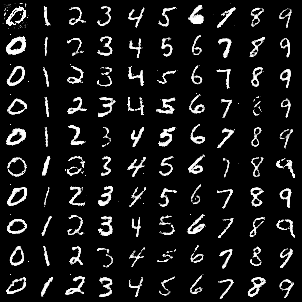

In [105]:
n_samples=10
def layer_hook(act_dict, layer_name):
    def hook(module, input, output):
        act_dict[layer_name] = output
    return hook
def act_max(model, generator, steps, alpha):
    z, labels = gen_GAN_noise(n_samples)
    cnn_act_dict, gan_act_dict = {}, {}
    cnn_layer = 'fc2'
    generator_layer = 'fc'
    list(model.children())[-1].register_forward_hook(layer_hook(cnn_act_dict, cnn_layer))
    list(generator.children())[-1].register_forward_hook(layer_hook(gan_act_dict, generator_layer))
    res_images = []
    inp_img = generator(z, labels)
    for k in range(steps):
        inp_img.requires_grad_(True)
        inp_img.retain_grad()
        # Propagate image
        output = model(inp_img)

        # Compute gradients
        cnn_layer_out = cnn_act_dict[cnn_layer]
        cnn_layer_out[0][0].backward(retain_graph=True)
        inp_img = torch.add(inp_img, torch.mul(inp_img.grad, alpha))
        new_norm = torch.norm(inp_img)
        # new_img = torch.mul(inp_img, old_norm/new_norm)
        if k % 100 == 0:
            torch.cuda.empty_cache()
    return inp_img
x = act_max(model, generator, 100, 0.5)
grid = make_grid(x, nrow=10)
ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to("cpu", torch.uint8).numpy()
im = Image.fromarray(ndarr)
display(im)

### Evaluation of project
The project does seem to generate images that one would consider representative of their respective classes! There is some extra static or irregularities in some images (like not-quite-solid lines), but generally the '1's look like a 1 and so on! This approach has some particularly interesting aspects -- it uses generative models as a tool to explain other models, and we can mix and match generators with models-to-be-explained as long as the output of the former corresponds to the input of the latter, giving it remarkable flexibility. In the end, though, I don't think this counts as a perfect solution to explaining convolutional neural networks. First of all, philosophically, it's debatable as to the extent to which asking the model to produce what it believes to be representative images of each class can truly be considered a fidelitous and descriptive explanation of the model's classification decision-making. Secondly, we're trying to explain the black-box classifier using another black-box models: the generator. To some extent, we are convoluting things by adding this dependency on the effectiveness of the generator. Thus, the trustworthiness of this method is even more debatable. Regardless, it's an interesting approach to a very hard, unsolved problem.